In [ ]:
%run ./ESE527_project_setup.ipynb
%run ./Metrics.py

## Classification with outlier detection

### Split dataset

In [2]:
features=data_db.drop(['Rating', 'Rating Interval'],axis=1)
label=data_db['Rating Interval']
standardized_features=Standardization(features)
train_X,test_X,train_Y,test_Y=train_test_split(standardized_features,label,test_size=0.2,random_state=527)
smote = SMOTE()
# Fit and apply SMOTE
train_X, train_Y = smote.fit_resample(train_X, train_Y)

## XGBoost

In [3]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'booster':trial.suggest_categorical('booster',['gbtree']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
    }
    model = XGBClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2024-07-06 09:53:00,247] A new study created in memory with name: no-name-f0b79a48-3bd1-4102-8d26-0910a8e369f5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-07-06 09:53:10,773] Trial 0 finished with value: 0.7439338484478787 and parameters: {'n_estimators': 116, 'max_depth': 15, 'booster': 'gbtree', 'learning_rate': 0.041184824405284474}. Best is trial 0 with value: 0.7439338484478787.
[I 2024-07-06 09:53:25,511] Trial 1 finished with value: 0.7423071709366952 and parameters: {'n_estimators': 150, 'max_depth': 15, 'booster': 'gbtree', 'learning_rate': 0.017402062718066113}. Best is trial 0 with value: 0.7439338484478787.
[I 2024-07-06 09:53:33,513] Trial 2 finished with value: 0.748949437440694 and parameters: {'n_estimators': 150, 'max_depth': 9, 'booster': 'gbtree', 'learning_rate': 0.03900350631900732}. Best is trial 2 with value: 0.748949437440694.
[I 2024-07-06 09:53:42,445] Trial 3 finished with value: 0.7503050020333468 and parameters: {'n_estimators': 142, 'max_depth': 10, 'booster': 'gbtree', 'learning_rate': 0.028656790475184043}. Best is trial 3 with value: 0.7503050020333468.
[I 2024-07-06 09:53:49,543] Trial 4 finished

In [4]:
clf_XGB= XGBClassifier(**best_params)
clf_XGB.fit(train_X, train_Y)
y_pred_XGB=clf_XGB.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred_XGB)
print("Accuracy of XGBoost: ",accuracy)

Accuracy of XGBoost:  0.43902439024390244


In [5]:
importances = clf_XGB.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Reviews                        0.397633
 2) Installs                       0.356557
 3) Content Rating_Everyone        0.146479
 4) Genres_Entertainment           0.068234
 5) Category_BOOKS_AND_REFERENCE   0.031097
 6) Genres_Casual;Pretend Play     0.000000
 7) Genres_Adventure;Education     0.000000
 8) Genres_Art & Design;Pretend Play 0.000000
 9) Genres_Art & Design;Creativity 0.000000
10) Genres_Art & Design            0.000000
11) Genres_Arcade;Pretend Play     0.000000
12) Genres_Arcade;Action & Adventure 0.000000
13) Genres_Arcade                  0.000000
14) Genres_Adventure;Brain Games   0.000000
15) Genres_Beauty                  0.000000
16) Genres_Adventure;Action & Adventure 0.000000
17) Genres_Adventure               0.000000
18) Genres_Action;Action & Adventure 0.000000
19) Genres_Action                  0.000000
20) Content Rating_Unrated         0.000000
21) Content Rating_Teen            0.000000
22) Content Rating_Mature 17+      0.000000
23) Genres_Auto & Veh

Accuracy: 0.43902439024390244
Precision: 0.7136178530972684
Recall: 0.43902439024390244
F1 Score: 0.5304382828547389


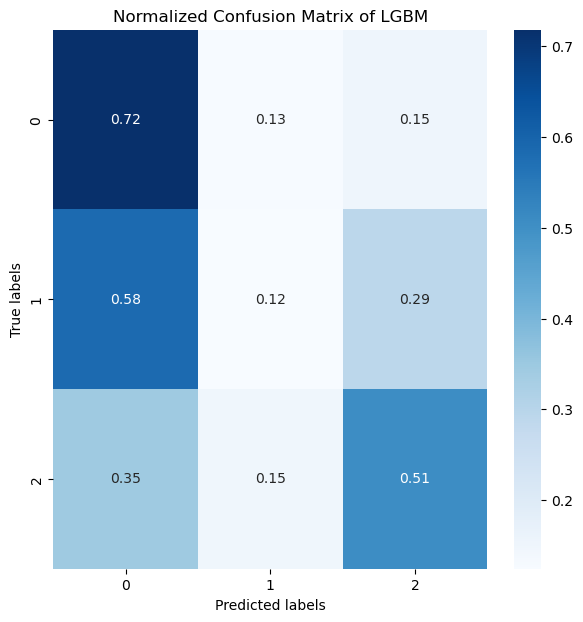

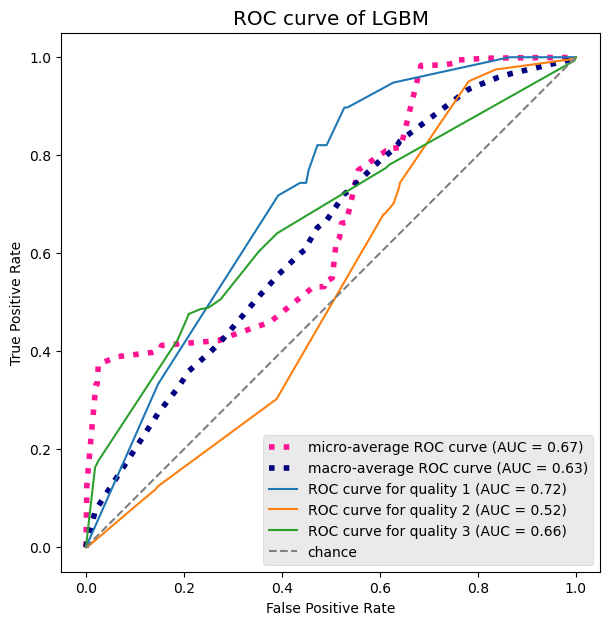

In [6]:
cm(test_X,test_Y,clf_XGB,'LGBM')
ROC(train_Y,test_Y,test_X,clf_XGB,'LGBM')

## Lightgbm


In [7]:
def objective(trial):
    params= {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2024-07-06 09:56:51,771] A new study created in memory with name: no-name-168c872d-269b-4904-841c-43bfc14a64d2


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.433798927649096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.433798927649096
[LightGBM] [Warning] bagging_fraction is set=0.8490094182790627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8490094182790627
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.433798927649096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.433798927649096
[LightGBM] [Warning] bagging_fraction is set=0.8490094182790627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8490094182790627
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001482 seconds.
Yo

In [8]:
clf_lgbm=lgbm.LGBMClassifier(**best_params)
clf_lgbm.fit(train_X, train_Y)
y_pred_lgbm=clf_lgbm.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred_lgbm)
accuracy

[LightGBM] [Warning] feature_fraction is set=0.5788595773497677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788595773497677
[LightGBM] [Warning] bagging_fraction is set=0.10033310648371004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10033310648371004
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5788595773497677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788595773497677
[LightGBM] [Warning] bagging_fraction is set=0.10033310648371004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10033310648371004
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850

0.5182926829268293

In [9]:
importances = clf_lgbm.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Installs                       1094.000000
 2) Reviews                        815.000000
 3) days_since_last_update         737.000000
 4) Size                           546.000000
 5) Category_FAMILY                118.000000
 6) Content Rating_Everyone        63.000000
 7) Category_TOOLS                 42.000000
 8) Genres_Entertainment           39.000000
 9) Genres_Tools                   14.000000
10) Category_GAME                  10.000000
11) Content Rating_Teen            4.000000
12) Type_Free                      1.000000
13) Price                          1.000000
14) Genres_Art & Design            0.000000
15) Genres_Board;Action & Adventure 0.000000
16) Genres_Board                   0.000000
17) Genres_Beauty                  0.000000
18) Genres_Auto & Vehicles         0.000000
19) Genres_Art & Design;Pretend Play 0.000000
20) Genres_Art & Design;Creativity 0.000000
21) Category_COMICS                0.000000
22) Genres_Board;Brain Games       0.000000
23) Genres_Ar

[LightGBM] [Warning] feature_fraction is set=0.5788595773497677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788595773497677
[LightGBM] [Warning] bagging_fraction is set=0.10033310648371004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10033310648371004
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Accuracy: 0.5182926829268293
Precision: 0.7104212814886578
Recall: 0.5182926829268293
F1 Score: 0.5889813671058066


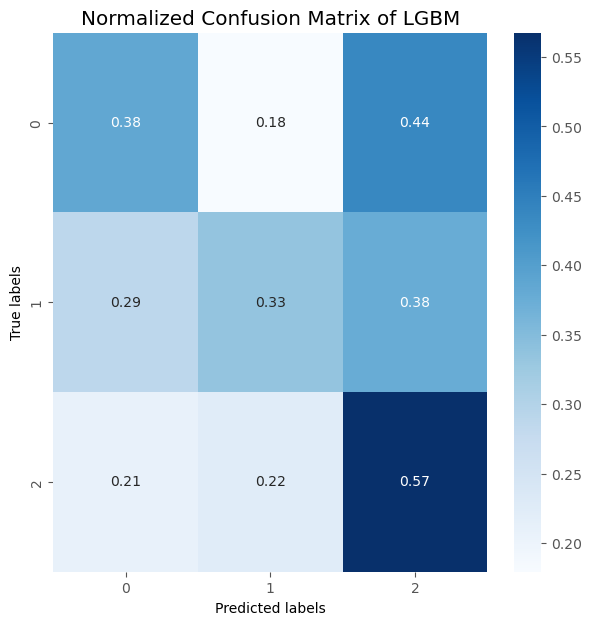

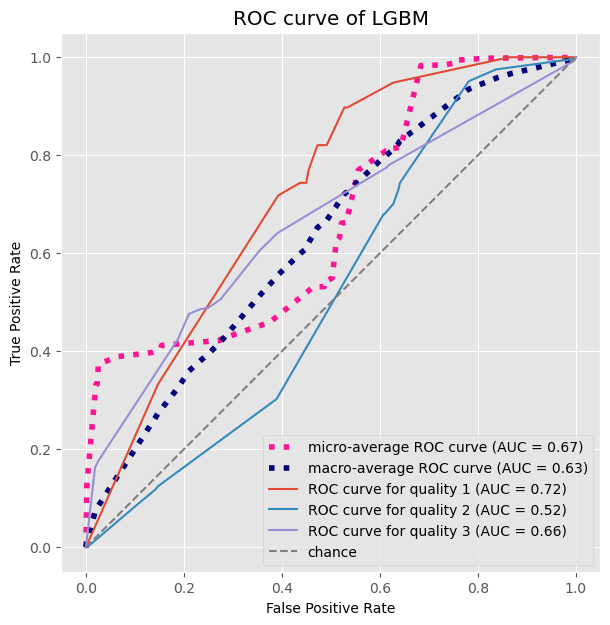

In [10]:
cm(test_X,test_Y,clf_lgbm,'LGBM')
ROC(train_Y,test_Y,test_X,clf_XGB,'LGBM')

## Catboost

In [11]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'depth': trial.suggest_int('depth', 1, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'task_type':trial.suggest_categorical('task_type',['GPU']),
        'loss_function':trial.suggest_categorical('loss_function',['MultiClass'])
    }
    model = cat.CatBoostClassifier(**params)
    model.fit(standardized_features, label)
    k_folds = 3
    cv_scores = cross_val_score(model, standardized_features, label, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2024-07-06 09:59:18,772] A new study created in memory with name: no-name-77ed9e0d-8226-4e61-ba6f-791e3311794a


  0%|          | 0/50 [00:00<?, ?it/s]

0:	learn: 1.0968879	total: 85.2ms	remaining: 5.36s
1:	learn: 1.0951610	total: 91ms	remaining: 2.82s
2:	learn: 1.0934592	total: 97.2ms	remaining: 1.98s
3:	learn: 1.0917661	total: 103ms	remaining: 1.55s
4:	learn: 1.0900823	total: 109ms	remaining: 1.29s
5:	learn: 1.0884056	total: 115ms	remaining: 1.11s
6:	learn: 1.0867406	total: 120ms	remaining: 981ms
7:	learn: 1.0850763	total: 126ms	remaining: 884ms
8:	learn: 1.0834567	total: 132ms	remaining: 806ms
9:	learn: 1.0818091	total: 137ms	remaining: 741ms
10:	learn: 1.0801638	total: 143ms	remaining: 687ms
11:	learn: 1.0785258	total: 148ms	remaining: 642ms
12:	learn: 1.0768968	total: 154ms	remaining: 604ms
13:	learn: 1.0752512	total: 159ms	remaining: 568ms
14:	learn: 1.0736286	total: 164ms	remaining: 536ms
15:	learn: 1.0720021	total: 169ms	remaining: 508ms
16:	learn: 1.0704086	total: 174ms	remaining: 482ms
17:	learn: 1.0688170	total: 180ms	remaining: 459ms
18:	learn: 1.0672231	total: 185ms	remaining: 438ms
19:	learn: 1.0656269	total: 190ms	remain

In [12]:
clf_cat= cat.CatBoostClassifier(**best_params)
clf_cat.fit(train_X, train_Y)
y_pred_cat=clf_cat.predict(test_X)
accuracy=accuracy_score(test_Y,y_pred_cat)
accuracy

0:	learn: 1.0891389	total: 15.6ms	remaining: 2.81s
1:	learn: 1.0804955	total: 17.4ms	remaining: 1.55s
2:	learn: 1.0725674	total: 18.6ms	remaining: 1.11s
3:	learn: 1.0653368	total: 19.9ms	remaining: 880ms
4:	learn: 1.0585454	total: 21.2ms	remaining: 745ms
5:	learn: 1.0523843	total: 22.5ms	remaining: 656ms
6:	learn: 1.0465465	total: 24ms	remaining: 595ms
7:	learn: 1.0411743	total: 25.2ms	remaining: 546ms
8:	learn: 1.0361042	total: 26.8ms	remaining: 512ms
9:	learn: 1.0311898	total: 29.3ms	remaining: 501ms
10:	learn: 1.0267705	total: 31.4ms	remaining: 486ms
11:	learn: 1.0226155	total: 33.5ms	remaining: 471ms
12:	learn: 1.0187123	total: 37.1ms	remaining: 479ms
13:	learn: 1.0149734	total: 38.6ms	remaining: 460ms
14:	learn: 1.0115923	total: 40.1ms	remaining: 443ms
15:	learn: 1.0086929	total: 41.4ms	remaining: 427ms
16:	learn: 1.0061690	total: 42.7ms	remaining: 412ms
17:	learn: 1.0029448	total: 44.2ms	remaining: 400ms
18:	learn: 1.0001315	total: 45.5ms	remaining: 388ms
19:	learn: 0.9979652	tot

0.5115176151761518

In [13]:
importances = clf_cat.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_X.columns
for f in range(train_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Installs                       38.861339
 2) Reviews                        37.400589
 3) days_since_last_update         9.291531
 4) Content Rating_Everyone        4.305772
 5) Genres_Entertainment           2.649516
 6) Type_Free                      2.068421
 7) Type_Paid                      1.475697
 8) Category_TOOLS                 0.809188
 9) Category_PERSONALIZATION       0.746235
10) Category_HEALTH_AND_FITNESS    0.562407
11) Genres_Personalization         0.488273
12) Content Rating_Teen            0.335879
13) Category_BOOKS_AND_REFERENCE   0.250775
14) Genres_Books & Reference       0.249990
15) Genres_Health & Fitness        0.234341
16) Genres_Tools                   0.164405
17) Genres_Lifestyle               0.105641
18) Genres_Adventure;Action & Adventure 0.000000
19) Genres_Arcade;Action & Adventure 0.000000
20) Genres_Arcade                  0.000000
21) Genres_Adventure;Education     0.000000
22) Genres_Adventure;Brain Games   0.000000
23) Genres_Trivia      

Accuracy: 0.5115176151761518
Precision: 0.7389274907079477
Recall: 0.5115176151761517
F1 Score: 0.5892126136794988


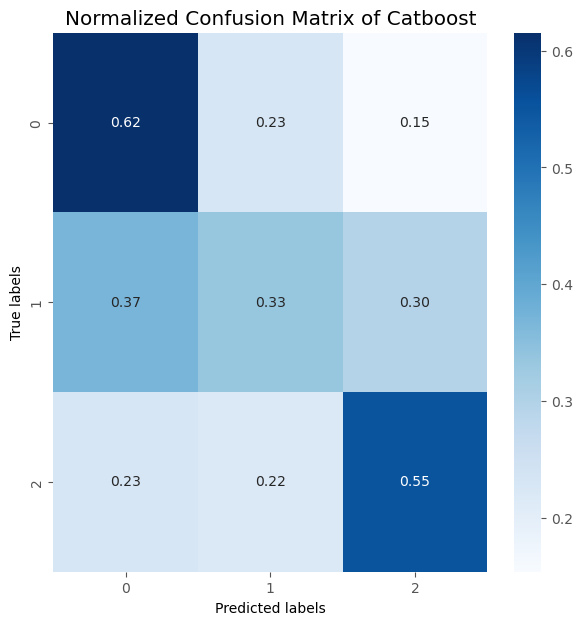

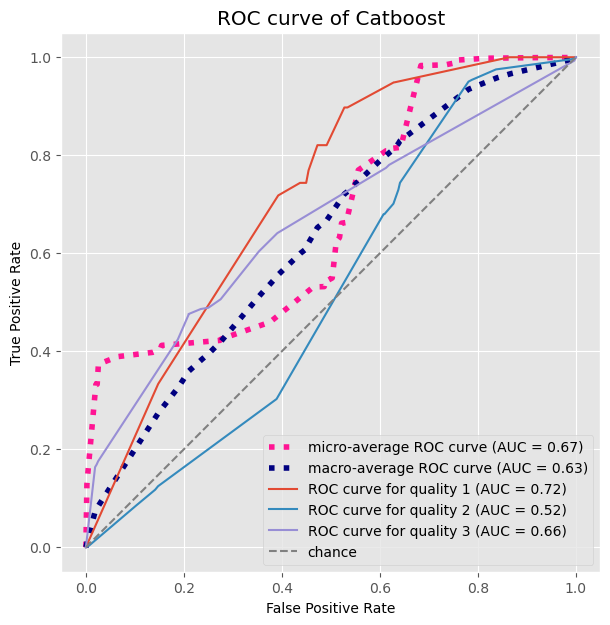

In [14]:
cm(test_X,test_Y,clf_cat,'Catboost')
ROC(train_Y,test_Y,test_X,clf_XGB,'Catboost')

In [15]:
def weight(weight):
    new=[]
    for i in range(0,len(test_X)):
        Y=int(weight[0]*y_pred_XGB[i]+weight[1]*y_pred_lgbm[i]+weight[2]*y_pred_cat[i])
        new.append(round(Y,0))
    return new

def Voting():
    new=[]
    for i in range(0,len(test_X)):
        Y=statistics.mode([y_pred_XGB[i],y_pred_lgbm[i],int(y_pred_cat[i])])
        new.append(Y)
    return new

### Final Accuracy

In [18]:
accuracy=accuracy_score(test_Y,Voting())
print(accuracy)

0.4817073170731707


In [45]:
# features=data_db[['Size','days_since_last_update','Installs','Reviews']]
# label=data_db['Rating Interval']
# standardized_features=Standardization(features)
# train_X,test_X,train_Y,test_Y=train_test_split(standardized_features,label,test_size=0.2,random_state=527)
# smote = SMOTE()
# # Fit and apply SMOTE
# train_X, train_Y = smote.fit_resample(train_X, train_Y)